In [11]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
import numpy as np
from unidecode import unidecode
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
"""Get ready to scrape the data- format the names"""
#This is the databse of names to scrape:
df = pd.read_csv('riderlistcsv.csv')
df.head()

# define a function to remove accents
def remove_accents(text):
    return unidecode(text)

#Remove accents
df['Name_clean'] = df['Name'].apply(remove_accents)
#Remove trailing spaces
df['Name_clean'] = df['Name_clean'].str.strip()
# replace spaces with a dash in the Name column
df['Name_clean'] = df['Name_clean'].str.replace(' ', '-')
df.head()


,type,Points,Name,url_fix,Name_clean
0,All Rounder,26,Remco Evenepoel,NaN,Remco-Evenepoel
1,All Rounder,24,Primož Roglič,NaN,Primoz-Roglic
2,All Rounder,18,Geraint Thomas,NaN,Geraint-Thomas
3,All Rounder,16,João Almeida,NaN,Joao-Almeida
4,All Rounder,14,Aleksandr Vlasov,NaN,Aleksandr-Vlasov


In [3]:
""" Scrape points data from PCS OR Load data"""

#Choose whether to scrape:
collect = 0

if collect:
    for index, row in df.iterrows():
        #If I haven't entered as custom URL, use the first and last name
        if pd.isnull(row['url_fix']):
            urlname = row['Name_clean']
            url = f"http://www.procyclingstats.com/rider/{urlname}"
        else:
            url = row['url_fix']
             
        print(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        rdr_info_find = soup.find_all('div', class_='rdr-info-cont')
        text = rdr_info_find[0].text

        #Extract additional stats from this text
        try:
            age = re.findall(r'Date of birth:.*?\((\d+)\)', text)[0]
            weight = re.findall(r'Weight: (\d+) kg', text)[0]
            height = re.findall(r'Height: (\d+\.\d+) m', text)[0]
            oneday = re.findall(r"Points per specialty(\d+)", text)[0]
            GC = re.findall(r"One day races(\d+)", text)[0]
            TT = re.findall(r"GC(\d+)", text)[0]
            sprint = re.findall(r"Time trial(\d+)", text)[0]
            climber = re.findall(r"Sprint(\d+)", text)[0]
            
            #Store all of these stats 
            var_store = {'dob':age,'weight':weight,'height':height,'oneday':oneday,'GC':oneday,'TT':TT,'sprint':sprint,'climber':climber}
            for var_add in var_store:
                df.loc[index,var_add] = var_store[var_add]
                print(var_store[var_add])
        except:
            print("Issue with rider stats")    
            
        #Find points per year 
        my_spans = soup.find_all('table', class_='basic rdr-season-stats')

        for select_span in my_spans:
            rows_find = select_span.find_all('tr')
            for idx, row_ht in enumerate(rows_find):
                if idx == 0:
                    continue

                cols = row_ht.find_all('td')
                year = cols[0].text.strip()
                score = cols[1].find('span').text.strip()
                #print(f'Year: {year}, Score: {score}')
                row[year] = score
                df.loc[index,year] = score
        
    df.to_csv('saved_scrape_new.csv')

else:
    #These results were saved BEFORE the Giro started
    df = pd.read_csv('saved_scrape.5.5.23.csv')
    #Collect caruso's cost (was a type in the May 5th dataset)
    df.loc[df['Name']=='Damiano Caruso','Points']=10
    df = df.rename(columns={"dob": "age","Points":"Cost"})

In [4]:
#Convert scraped string variables to numeric
cols_to_convert = [col for col in list(df.columns) if col not in ['type','Name','Name_clean']]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
df.head()

,Unnamed: 0,type,Cost,Name,url_fix,Name_clean,age,weight,height,oneday,...,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,0,All Rounder,26,Remco Evenepoel,NaN,Remco-Evenepoel,23.0,61.0,1.71,1889.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,All Rounder,24,Primož Roglič,NaN,Primoz-Roglic,33.0,65.0,1.77,1537.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,All Rounder,18,Geraint Thomas,NaN,Geraint-Thomas,36.0,71.0,1.83,1236.0,...,565.0,308.0,55.0,36.0,32.0,43.0,2.0,NaN,NaN,NaN
3,3,All Rounder,16,João Almeida,NaN,Joao-Almeida,24.0,63.0,1.78,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,All Rounder,14,Aleksandr Vlasov,NaN,Aleksandr-Vlasov,27.0,68.0,1.86,918.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Avg. Improvement by Age
old_young
Young    1.220116
Old      0.872738
Name: mean_impr, dtype: float64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

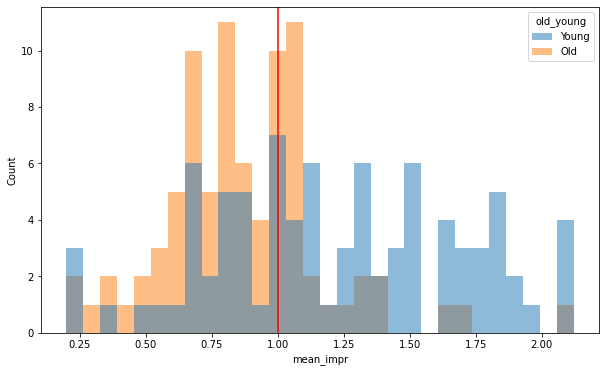

In [43]:
""" Define valuation metrics """

#Extrapolate the 2023 Data to a full year
scale_factor = df['2022'].mean()/df['2023'].mean()
df['2023'] = df['2023']*scale_factor

#Average points over past 3 years
df['points_past3'] = ((df['2023']+df['2022']+df['2021'])/3).round(2)

""" Calculate an average improvement score """

ylist = ['2023','2022','2021','2020']

#Take log of yearly imrpovement such that data is less skewed by large improvements
templist = list()
for i in range(0,len(ylist)-1):
    plt.figure()
    newname = f'impr_{ylist[i]}'
    templist.append(newname)
    df[newname] = np.log(df[ylist[i]]/df[ylist[i+1]])

#Average the improvements
df['mean_impr'] = df[templist].mean(axis=1)

#Cap outliers
upper_pct = df['mean_impr'].quantile(0.98)
df['mean_impr'] = df['mean_impr'].clip(upper=upper_pct)
lower_pct = df['mean_impr'].quantile(0.02)
df['mean_impr'] = df['mean_impr'].clip(lower=lower_pct)

#Recenter at 1
df['mean_impr'] = df['mean_impr'] + 1
df['mean_impr'] = (df['mean_impr']/df['mean_impr'].median()).round(2)

#Add a few more features
df['old_young'] = pd.qcut(df['age'], q=2, labels=['Young', 'Old'])
df['tall_short'] = pd.qcut(df['height'], q=2, labels=['short', 'Tall'])
df['heavy_list'] = pd.qcut(df['weight'], q=2, labels=['light', 'heavier'])

print('Avg. Improvement by Age')
print(df.groupby('old_young')['mean_impr'].mean())

#Plot improvements vs Age
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x='mean_impr',bins =30, hue='old_young', stat='count', edgecolor=None)
ax.axvline(x = df['mean_impr'].median(), color = 'r')


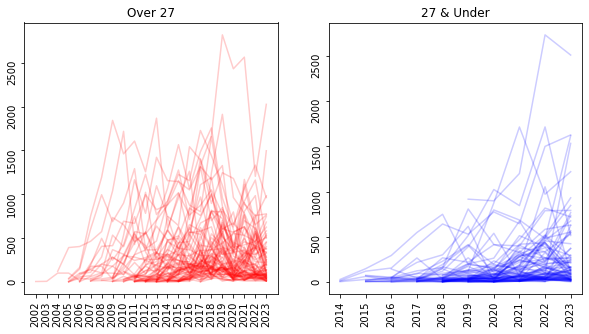

In [44]:
#Plot improvement over time by age by transposing the DF
dft = df.set_index('Name')
dft = dft.filter(regex='^20')
dft = dft.transpose()
dft = dft.iloc[::-1, :]

fig, axs = plt.subplots(1,2, figsize = (10, 5))

#Get a list of names for the older riders (Over 27)
old_names = df.loc[(df['old_young'] == 'Old'), 'Name'].tolist()

for col in dft.columns:
    if col in old_names:
        cplot = 'r'
        axs[0].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[0].tick_params(rotation=90)
        axs[0].set_title('Over 27')
    else:
        cplot = 'b'
        axs[1].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[1].tick_params(rotation=90)
        axs[1].set_title('27 & Under')
    

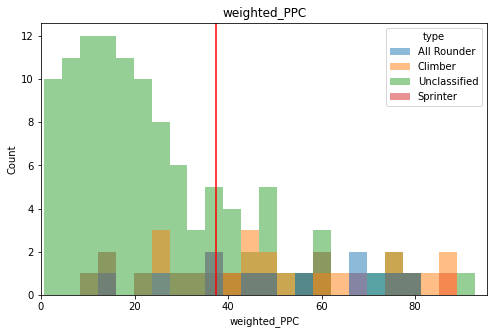

In [45]:
# PPC stands for points per cost, this will be the metric to focus on optimizing
df['weighted_points'] = df['points_past3']*df['mean_impr']
df['weighted_PPC'] = (df['weighted_points']/df['Cost']).round(2)

score_metric ='weighted_PPC'
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x=score_metric, bins =50, hue='type', stat='count', edgecolor=None)
ax.set_title(score_metric)
#Set axis limits
ax.set_xlim(0,df[score_metric].quantile(0.95))
#Red line denotes the mean
ax.axvline(x = df[score_metric].mean(), color = 'r')

In [46]:
#Get a list of the best value riders in each category
df_disp = df[['Name','type','age','Cost','weighted_PPC','mean_impr']]

for type_name in df_disp['type'].unique():
    df_disp_cut = df_disp[df_disp['type'] == type_name]
    tabplot = df_disp_cut.nlargest(10, 'weighted_PPC')
    display(tabplot)

,Name,type,age,Cost,weighted_PPC,mean_impr
0,Remco Evenepoel,All Rounder,23.0,26,98.29,1.19
3,João Almeida,All Rounder,24.0,16,79.73,0.98
11,Diego Ulissi,All Rounder,33.0,8,76.80,0.76
7,Brandon McNulty,All Rounder,25.0,10,70.61,1.07
10,Bauke Mollema,All Rounder,36.0,8,67.51,0.79
1,Primož Roglič,All Rounder,33.0,24,66.80,0.83
12,Rigoberto Urán,All Rounder,36.0,8,54.61,0.82
4,Aleksandr Vlasov,All Rounder,27.0,14,49.78,0.68
6,Pavel Sivakov,All Rounder,25.0,12,43.22,1.01
8,Warren Barguil,All Rounder,31.0,8,38.81,0.60


,Name,type,age,Cost,weighted_PPC,mean_impr
21,Santiago Buitrago,Climber,23.0,8,111.32,1.65
31,Einer Augusto Rubio,Climber,25.0,6,109.62,1.69
29,Patrick Konrad,Climber,31.0,6,88.85,0.94
33,Ilan Van Wilder,Climber,22.0,6,87.34,1.78
17,Damiano Caruso,Climber,35.0,10,82.12,1.06
22,Lorenzo Fortunato,Climber,26.0,8,78.90,1.52
15,Jay Vine,Climber,27.0,12,76.82,1.81
27,Alessandro Covi,Climber,24.0,6,74.99,1.13
19,Thibaut Pinot,Climber,32.0,10,65.46,1.03
26,Jefferson Alexander Cepeda,Climber,24.0,6,60.05,1.69


,Name,type,age,Cost,weighted_PPC,mean_impr
64,Ben Healy,Unclassified,22.0,6,192.42,2.12
40,Stefan Küng,Unclassified,29.0,8,141.71,1.01
80,Lorenzo Rota,Unclassified,27.0,6,140.52,1.26
36,Filippo Ganna,Unclassified,26.0,10,101.19,1.09
74,Aurélien Paret-Peintre,Unclassified,27.0,6,90.09,1.11
71,Henok Mulubrhan,Unclassified,23.0,6,79.36,1.50
42,Giovanni Aleotti,Unclassified,23.0,6,75.44,1.62
37,Magnus Cort,Unclassified,30.0,8,74.82,1.14
52,Simon Clarke,Unclassified,36.0,6,72.68,1.08
154,Stephen Williams,Unclassified,26.0,4,60.95,1.85


,Name,type,age,Cost,weighted_PPC,mean_impr
161,Mark Cavendish,Sprinter,37.0,8,134.78,1.69
157,Mads Pedersen,Sprinter,27.0,14,98.78,1.10
167,Vincenzo Albanese,Sprinter,26.0,6,88.12,1.48
174,Marius Mayrhofer,Sprinter,22.0,6,79.10,2.12
168,Davide Ballerini,Sprinter,28.0,6,75.91,1.03
160,Michael Matthews,Sprinter,32.0,10,68.92,0.80
164,Kaden Groves,Sprinter,24.0,8,61.10,1.31
159,Fernando Gaviria,Sprinter,28.0,10,58.33,1.07
175,Andrea Vendrame,Sprinter,28.0,6,55.21,0.90
172,Filippo Fiorelli,Sprinter,NaN,6,50.13,1.23


In [21]:
# This is the harder part, actually picking the team:
# You need to choose a certain number of each type of rider, maximize points
# I do a two step optimization, where I choose blocks of the top 5, and then pick the unclassified riders

#Get lists of each type of rider
ar_list = df.loc[df['type'] == 'All Rounder', 'Name'].tolist()
c_list = df.loc[df['type'] == 'Climber', 'Name'].tolist()
sp_list = df.loc[df['type'] == 'Sprinter', 'Name'].tolist()

#There are 5 slots to fill:
term_set = [ar_list,ar_list,c_list,c_list,sp_list]

#Calculate the max # of combos - Not sure how to sample from the same list without replacement...
max_choices = 1
for term in term_set:
    max_choices = max_choices*len(term)
    
#Use itertools to make all possible combinations taking rider from each set
i = 0

df_max = pd.DataFrame(index=range(max_choices),columns=range(1))
for var_set in itertools.product(*term_set):
    benefit = df.loc[df['Name'].isin(var_set), 'weighted_points'].sum()
    cost = df.loc[df['Name'].isin(var_set), 'Cost'].sum()
    df_max.loc[i,['AR1','AR2','C1','C2','S']] = list(var_set)
    df_max.loc[i,'benefit'] = benefit
    df_max.loc[i,'cost'] = cost
    i += 1
    
    # if i == 1000:
    #     break
    

In [22]:
"""Now need to pick unclassified, this is an issue as there are so many of then"""
# Work using the notation that the cheapest possible Unclassified set would be 4, 4 point riders
# Anyone with fewer points than the 4th rider should never be picked
df_disp_cut = df.loc[(df['type'] == 'Unclassified') & (df['Cost'] == 4)]
tabplot = df_disp_cut.nlargest(4, 'weighted_PPC')
display(tabplot)
uc_list = df.loc[(df['weighted_PPC'] >45) & (df['type'] == 'Unclassified'),'Name'].unique().tolist()

,Unnamed: 0,type,Cost,Name,url_fix,Name_clean,age,weight,height,oneday,...,impr_2023,impr_2022,impr_2021,mean_impr,old_young,tall_short,heavy_list,PPC,weighted_PPC,weighted_points
154,154,Unclassified,4,Stephen Williams,NaN,Stephen-Williams,26.0,59.0,1.83,120.0,...,0.515927,-0.845488,3.605498,1.847636,Young,Tall,light,32.94,60.87,243.481498
134,134,Unclassified,4,Laurenz Rex,NaN,Laurenz-Rex,23.0,82.0,1.93,222.0,...,1.127983,0.351398,NaN,1.536495,Young,Tall,heavier,32.35,49.71,198.837828
156,156,Unclassified,4,Samuele Zoccarato,NaN,Samuele-Zoccarato,25.0,74.0,1.83,128.0,...,1.305486,-0.182322,3.988984,2.116096,Young,Tall,heavier,22.08,46.73,186.935965
137,137,Unclassified,4,Clément Russo,NaN,Clement-Russo,28.0,73.0,1.86,388.0,...,0.124270,-0.277122,1.622259,1.315793,Old,Tall,heavier,34.23,45.04,180.158436


In [23]:
# Repeat the same step to get teams of 4 unclassified riders
term_set = [uc_list,uc_list,uc_list,uc_list]
df_max_uc = pd.DataFrame(index=range(len(uc_list)**4),columns=range(1))
i = 0
for var_set in itertools.product(*term_set):
    benefit = df.loc[df['Name'].isin(var_set), 'weighted_points'].sum()
    cost = df.loc[df['Name'].isin(var_set), 'Cost'].sum()
    df_max_uc.loc[i,['UC1','UC2','UC3','UC4']] = list(var_set)
    df_max_uc.loc[i,'benefit'] = benefit
    df_max_uc.loc[i,'cost'] = cost
    i += 1

In [40]:
#Get rid of teams where a rider is picked twice
df_max_uc_dedup = df_max_uc.loc[(df_max_uc['UC1'] != df_max_uc['UC2']) & (df_max_uc['UC1'] != df_max_uc['UC3']) & (df_max_uc['UC2'] != df_max_uc['UC3']) & (df_max_uc['UC1'] != df_max_uc['UC4'])& (df_max_uc['UC2'] != df_max_uc['UC4'])& (df_max_uc['UC3'] != df_max_uc['UC4'])]

#Using the fact that the constraint is 100, loop over the possible costs of unclassified, to see the resulting classified team

df_final_teams = pd.DataFrame()
for num in range(16, 35, 2):

    leftover = 100-num
 
    #Get the main 5
    df_disp = df_max[df_max['cost'] == leftover]
    tabplot_main = df_disp.nlargest(1, 'benefit').reset_index()
    #display(tabplot)
    tabplot_main
    #sum_main5 = tabplot.loc[:,'benefit'].sum()
    #Get the Unclassified riders
    df_disp = df_max_uc_dedup[df_max_uc_dedup['cost'] == num]
    tabplot_uc = df_disp.nlargest(1, 'benefit').reset_index()
    tabplot_uc = tabplot_uc.rename(columns={"benefit": "benefit_uc"})
    #sum_uc = tabplot.loc[:,'benefit'].sum()
    #display(tabplot)
    df_add = pd.concat([tabplot_main, tabplot_uc],axis =1)
    #display(df_add)
    df_final_teams = pd.concat([df_final_teams, df_add],axis =0)
    #print(f'The team above yields a total benefit of: {benefit_total}')


df_final_teams['total_benefit'] = df_final_teams['benefit'] + df_final_teams['benefit_uc']
df_final_teams = df_final_teams[['AR1','AR2','C1','C2','S','UC1','UC2','UC3','UC4','total_benefit']]
df_final_teams = df_final_teams.nlargest(1, 'total_benefit').reset_index()
display(df_final_teams)

,index,AR1,AR2,C1,C2,S,UC1,UC2,UC3,UC4,total_benefit
0,0,Remco Evenepoel,João Almeida,Santiago Buitrago,Einer Augusto Rubio,Mads Pedersen,Filippo Ganna,Stefan Küng,Ben Healy,Lorenzo Rota,10893.401206


In [50]:
uc_list_full = df.loc[df['type'] == 'Unclassified', 'Name'].tolist()
total_term_set = [ar_list,ar_list,c_list,c_list,sp_list,uc_list_full,uc_list_full,uc_list_full,uc_list_full]
#times_used = {'ar_list'}
#Calculate the max # of combos - Not sure how to sample from the same list without replacement...
max_choices = 1
for term in total_term_set:
    count = len(term) 
    print(count)
    max_choices = max_choices*count
    term.pop()
    
print(f'total possible combinations: {max_choices}')
    

9
8
19
18
17
121
120
119
118
total possible combinations: 85349918142720
